In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os, os.path
from PIL import Image

TRAIN_DIR = 'input/train'
TEST_DIR = 'input/test_stg1'

In [2]:
category = sorted(os.listdir(TRAIN_DIR))[1:]
num_classes = len(category)
category

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [3]:
print('Number of train images')
category_num_list = []
for cat in category:
    n = len(os.listdir(os.path.join(TRAIN_DIR, cat)))
    print('%s: %d' % (cat, n))
    category_num_list.append(n)
print('-'*10)
print('Total: %d' % sum(category_num_list))
print('')
print('Number of test images')
print('Total:', len(os.listdir(TEST_DIR)))

Number of train images
ALB: 1719
BET: 200
DOL: 117
LAG: 67
NoF: 465
OTHER: 299
SHARK: 176
YFT: 734
----------
Total: 3777

Number of test images
Total: 1000


In [4]:
img_size_list = []
for cat in category:
    for filename in os.listdir(os.path.join(TRAIN_DIR, cat)):
        img = Image.open(os.path.join(TRAIN_DIR, cat, filename))
        img_size_list.append(img.size)
img_size_list_np = np.asarray(img_size_list)

print('unique width:', np.unique(img_size_list_np[:,0]))
print('unique height:', np.unique(img_size_list_np[:,1]))

unique width: [1192 1244 1276 1280 1334 1518 1732]
unique height: [670 700 718 720 750 854 924 974]


In [5]:
width_sr = pd.Series(img_size_list_np[:,0]).value_counts()
height_sr = pd.Series(img_size_list_np[:,1]).value_counts()

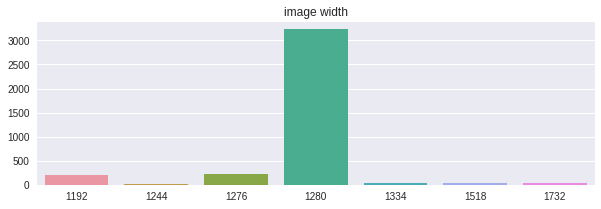

In [6]:
fig = plt.figure(figsize=(10,3))
sns.barplot(width_sr.index, width_sr.values)
plt.title('image width')
plt.show()

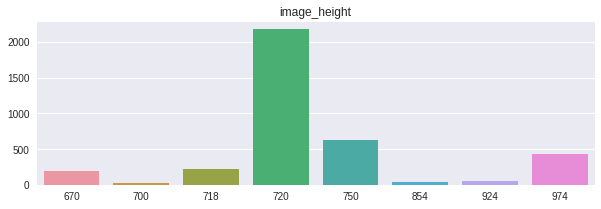

In [7]:
fig = plt.figure(figsize=(10,3))
sns.barplot(height_sr.index, height_sr.values)
plt.title('image_height')
plt.show()

In [8]:
# resize image (width, height) -> (200, 120)
width, height, channel = (200, 120, 3)
train_rows = sum(category_num_list)
x_train = np.empty((train_rows, height, width, channel), dtype=np.float32)
y_train = np.empty((train_rows,), dtype=np.float32)

test_rows = len(os.listdir(TEST_DIR))
x_test = np.empty((test_rows, height, width, channel), dtype=np.float32)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3777, 120, 200, 3)
(3777,)
(1000, 120, 200, 3)


In [9]:
print('load train images')
idx = 0
for i, cat in enumerate(category):
    for filename in os.listdir(os.path.join(TRAIN_DIR, cat)):
        img = Image.open(os.path.join(TRAIN_DIR, cat, filename))
        img = img.resize((width, height))
        x_train[idx] = np.array(img)
        y_train[idx] = i
        idx += 1
        if idx%500 == 0:
            print('load %d/%d' % (idx, train_rows))
print('load %d/%d' % (idx, train_rows))
print('')

print('load test images')
idx = 0
for filename in os.listdir(TEST_DIR):
    img = Image.open(os.path.join(TEST_DIR, filename))
    img = img.resize((width, height))
    x_test[idx] = np.array(img)
    idx += 1
    if idx%200 == 0:
        print('load %d/%d' % (idx, test_rows))

load train images
load 500/3777
load 1000/3777
load 1500/3777
load 2000/3777
load 2500/3777
load 3000/3777
load 3500/3777
load 3777/3777

load test images
load 200/1000
load 400/1000
load 600/1000
load 800/1000
load 1000/1000


In [10]:
import keras
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
print(y_train.shape)

Using TensorFlow backend.


(3777, 8)


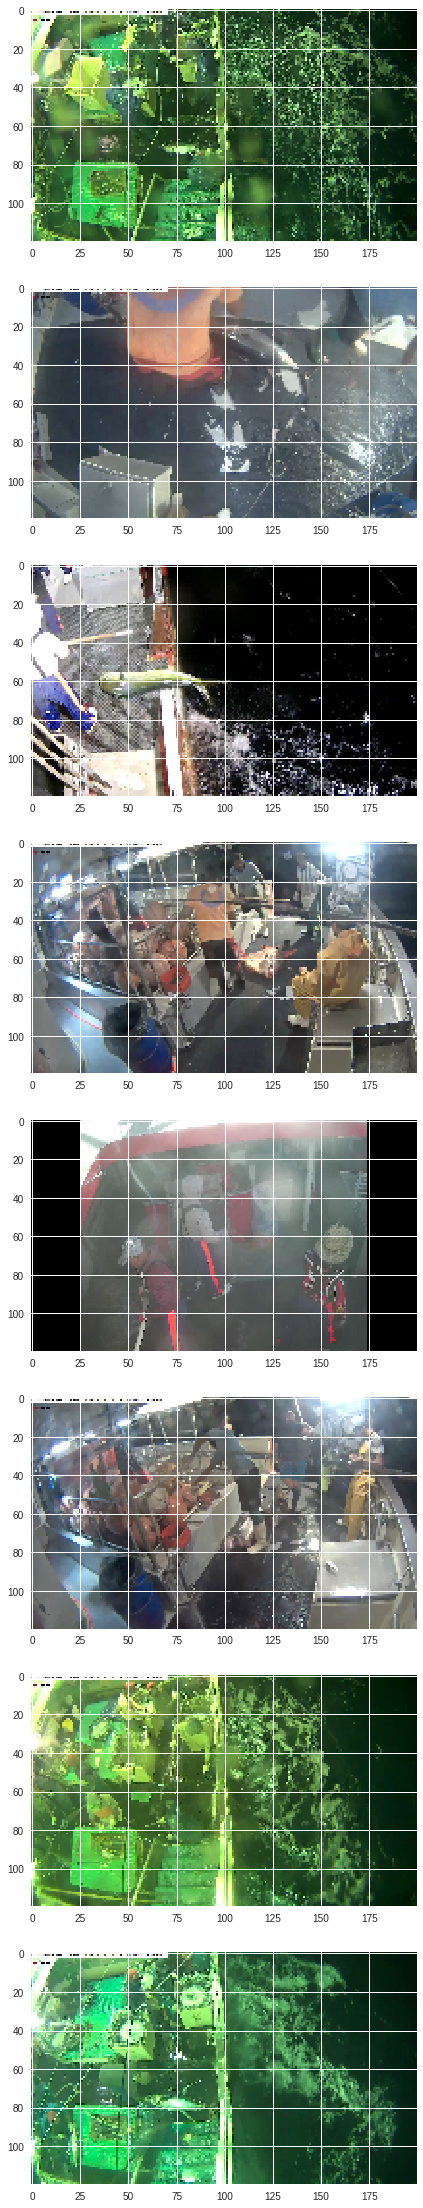

In [11]:
idx = np.append([0], np.cumsum(category_num_list))[:-1]
fig = plt.figure(figsize=(10,40))
for i in range(8):
    img = x_train[idx[i]]
    ax = fig.add_subplot(8,1,i+1)
    ax.imshow(img)
plt.show()

# CNN example

In [12]:
print(x_train.shape)
print(y_train.shape)

(3777, 120, 200, 3)
(3777, 8)


In [13]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rotation_range=180, width_shift_range=0.2, height_shift_range=0.2,
                            horizontal_flip=True, vertical_flip=True)

train_generator.fit(x_train)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(16, kernel_size=(5,5), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5))
model.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 120, 200, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 200, 16)      6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 100, 16)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 100, 32)       12832     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 100, 32)       25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 50, 64)        51264     
__________

In [15]:
batch_size = 32
epochs = 50
model.fit_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(x_train)//batch_size, epochs=epochs, verbose=2)

Epoch 1/50
20s - loss: 2.2848 - acc: 0.2773
Epoch 2/50
17s - loss: 1.9121 - acc: 0.3866
Epoch 3/50
17s - loss: 1.7909 - acc: 0.4070
Epoch 4/50
17s - loss: 1.7401 - acc: 0.4163
Epoch 5/50
17s - loss: 1.6947 - acc: 0.4319
Epoch 6/50
17s - loss: 1.6687 - acc: 0.4391
Epoch 7/50
17s - loss: 1.6319 - acc: 0.4494
Epoch 8/50
17s - loss: 1.6376 - acc: 0.4381
Epoch 9/50
17s - loss: 1.6797 - acc: 0.4277
Epoch 10/50
18s - loss: 1.6277 - acc: 0.4422
Epoch 11/50
18s - loss: 1.6151 - acc: 0.4325
Epoch 12/50
18s - loss: 1.5907 - acc: 0.4438
Epoch 13/50
18s - loss: 1.5671 - acc: 0.4529
Epoch 14/50
18s - loss: 1.7034 - acc: 0.4327
Epoch 15/50
18s - loss: 1.6504 - acc: 0.4341
Epoch 16/50
18s - loss: 1.6405 - acc: 0.4354
Epoch 17/50
18s - loss: 1.5992 - acc: 0.4357
Epoch 18/50
18s - loss: 1.5643 - acc: 0.4576
Epoch 19/50
18s - loss: 1.5747 - acc: 0.4568
Epoch 20/50
18s - loss: 1.5764 - acc: 0.4536
Epoch 21/50
18s - loss: 1.5506 - acc: 0.4541
Epoch 22/50
18s - loss: 1.5542 - acc: 0.4555
Epoch 23/50
18s - l

In [16]:
y_pred = model.predict(x_test, batch_size=32, verbose=1)
print(y_pred.shape)
print(y_pred[:3])

1000/1000 [==============================] - 1s     

In [17]:
submissions = pd.DataFrame(y_pred, columns=category)
submissions['image'] = os.listdir(TEST_DIR)
submissions.head()

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT,image
0,0.683590,0.049344,0.006656,0.017114,0.056428,0.096401,0.010369,0.080097,img_01803.jpg
1,0.713155,0.043933,0.005262,0.016375,0.041372,0.091118,0.010800,0.077984,img_00724.jpg
2,0.734955,0.043399,0.004015,0.016476,0.033530,0.100346,0.008298,0.058979,img_00551.jpg
3,0.326185,0.033895,0.047481,0.008590,0.320250,0.050425,0.017654,0.195520,img_02372.jpg
4,0.348770,0.052580,0.014326,0.009012,0.082278,0.088622,0.101117,0.303295,img_06522.jpg


In [18]:
submissions.to_csv('submissions.csv', index=False)